In [1]:
from dotenv import load_dotenv
load_dotenv()

True

# Deepagent for Research

We will use the `deepagents` package to create a research agent. When using the `deepagents` package, it's important to: 

1. Understand the native tools available
2. Supply task-specific tools
3. Supply task-specific instructions
4. Supply task-specific sub-agents

## Task-Specific Tools 

You can see an overview of the native tools in the [deepagents package README](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#model) as well as the [quickstarts README](https://github.com/langchain-ai/deepagents-quickstarts). We'll extend this with two task-specific tools. 

### Search Tool 

There are different search tools that we can use. For example, we can use [Tavily](https://www.tavily.com/) to search for relevant URLs, then fetches the full webpage content.

### Think Tool 

We'll supply a [think tool](https://www.anthropic.com/engineering/claude-think-tool), which is a useful way to help audit agent decision making. 

In [2]:
from research.tools import tavily_search, think_tool
tools = [tavily_search, think_tool]

## Task-Specific Instructions
 
Next, let's define task specific instructions using [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

In [3]:
from datetime import datetime
from utils import show_prompt, format_messages
from research.prompts import (
    RESEARCHER_INSTRUCTIONS,
    RESEARCH_WORKFLOW_INSTRUCTIONS,
    SUBAGENT_DELEGATION_INSTRUCTIONS,
)

In [4]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the research tools provided to you to find resources that can help answer the research      │
│  question.                                                                                                      │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Research Tools>                                                                                     │
│  You have access to two specific research tools:                                                                │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Research Tools>                                                                                    │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

## Task-Specific Sub-Agents

You can specify [custom subagents](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#subagents) as a means of context isolation. 

Here's well define a sub-agent that can search the web for information. 

In [5]:
# Get current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=current_date),
    "tools": [tavily_search, think_tool],
}

## Putting it all together

### Instructions

Now, we can look at all of our instructions together. 

In [6]:
# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Combine orchestrator instructions (RESEARCHER_INSTRUCTIONS only for sub-agents)
INSTRUCTIONS = (
    RESEARCH_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    +  SUBAGENT_DELEGATION_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
    )
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Research Workflow                                                                                            │
│                                                                                                                 │
│  Follow this workflow for all research requests:                                                                │
│                                                                                                                 │
│  1. **Plan**: Create a todo list with write_todos to break down the research into focused tasks                 │
│  2. **Save the request**: Use write_file() to save the user's research question to `/research_request.md`       │
│  3. **Research**: Delegate research tasks to sub-agents using the task() tool - ALWAYS use sub-agents for       │
│  research, never conduct research yourself                                                                      │
│  4. **Synthesize**: Review all sub-agent findings and consolidate citations (each unique URL gets one number    │
│  across all findings)                                                                                           │
│  5. **Write Report**: Write a comprehensive final report to `/final_report.md` (see Report Writing Guidelines   │
│  below)                                                                                                         │
│  6. **Verify**: Read `/research_request.md` and confirm you've addressed all aspects with proper citations and  │
│  structure                                                                                                      │
│                                                                                                                 │
│  ## Research Planning Guidelines                                                                                │
│  - Batch similar research tasks into a single TODO to minimize overhead                                         │
│  - For simple fact-finding questions, use 1 sub-agent                                                           │
│  - For comparisons or multi-faceted topics, delegate to multiple parallel sub-agents                            │
│  - Each sub-agent should research one specific aspect and return findings                                       │
│                                                                                                                 │
│  ## Report Writing Guidelines                                                                                   │
│                                                                                                                 │
│  When writing the final report to `/final_report.md`, follow these structure patterns:                          │
│                                                                                                                 │
│  **For comparisons:**                                                                                           │
│  1. Introduction                                                                                                │
│  2. Overview of topic A                                                                                         │
│  3. Overview of topic B                                                                                         │
│  4. Detailed comparison                                                                                         │
│  5. Conclusion                                                                                                  │
│                                                                                                                 │
│  **For lists/rankings:**                              

### Create the agent

Now, we create our deepagent with these components. 

In [8]:
from IPython.display import Image, display
from deepagents import create_deep_agent
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-3-pro-preview")


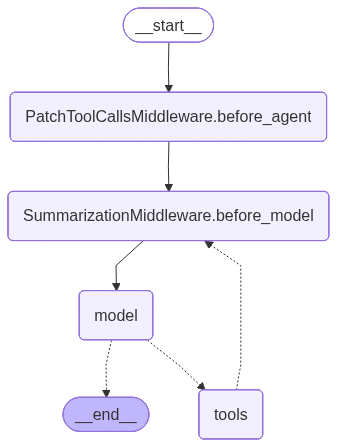

In [9]:
# Create the agent
agent = create_deep_agent(
      model=model,
      tools=tools, 
      system_prompt=INSTRUCTIONS,
      subagents=[research_sub_agent],
  )
  
# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [10]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "research context engineering approaches used to build AI agents",
            }
        ],
    }, 
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ research context engineering approaches used to build AI agents                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "in_progress",                                                                                  │
│       "content": "Save research request to /research_request.md"                                                │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Launch sub-agent to research context engineering approaches for AI agents"                    │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Synthesize findings and write final report to /final_report.md"                               │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 64be4d54-4bde-49a1-8539-767c41eb9bce                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md",                                                                          │
│   "content": "research context engineering approaches used to build AI agents"                                  │
│ }                                                                                                               │
│    ID: 78df20b0-630a-4b4b-a6a1-0deb2837e551                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'in_progress'},    │
│ {'content': 'Launch sub-agent to research context engineering approaches for AI agents', 'status': 'pending'},  │
│ {'content': 'Synthesize findings and write final report to /final_report.md', 'status': 'pending'}]             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /research_request.md                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Save research request to /research_request.md"                                                │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "in_progress",                                                                                  │
│       "content": "Launch sub-agent to research context engineering approaches for AI agents"                    │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Synthesize findings and write final report to /final_report.md"                               │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: d58fcb3f-8c38-4725-81c6-dc93de4119c5                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research context engineering approaches used to build AI agents.\n    \n    Focus on:\n    1. │
│ Definition and core concepts of context engineering in the context of AI agents.\n    2. Key techniques and     │
│ strategies, such as:\n       - Retrieval-Augmented Generation (RAG) for agents.\n       - Memory management     │
│ (short-term vs long-term, episodic vs semantic).\n       - Dynamic context selection and pruning (handling      │
│ context window limits).\n       - Prompt engineering techniques specific to agents (Chain of Thought, ReAct,    │
│ etc.).\n       - Tool use and context injection.\n    3. Architectural patterns (e.g., MemGPT, cognitive        │
│ architectures).\n    4. Challenges and best practices.\n    \n    Return a comprehensive summary with           │
│ citations. Ensure you list the specific URLs you used so I can cite them in the final report.",                 │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: bb545445-ce18-4ddf-b0b4-f10d9446b3c9                                                                     │
╰──────────────────────────────────────────────────────────

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'completed'},      │
│ {'content': 'Launch sub-agent to research context engineering approaches for AI agents', 'status':              │
│ 'in_progress'}, {'content': 'Synthesize findings and write final report to /final_report.md', 'status':         │
│ 'pending'}]                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Context engineering for AI agents is the discipline of designing, optimizing, and managing the information      │
│ within an agent's context window to ensure reliable reasoning, coherent long-term behavior, and efficient       │
│ resource usage. Unlike standard prompt engineering which focuses on single-turn optimization, context           │
│ engineering for agents deals with the dynamic lifecycle of information—how it is stored, retrieved, compressed, │
│ and utilized over time [2].                                                                                     │
│                                                                                                                 │
│ ### 1. Definition and Core Concepts                                                                             │
│ Context engineering establishes the "cognitive environment" in which an agent operates. It shifts focus from    │
│ just writing good instructions to building systems that manage the **flow of information** into the model [2].  │
│ *   **State Management**: Maintaining the agent's current status, goals, and progress (e.g., "in_progress",     │
│ "completed") to prevent loops and ensure task completion.                                                       │
│ *   **Information Hierarchy**: Structuring context into layers (System, Task, Tool, Memory) to prioritize       │
│ critical instructions over transient data.                                                                      │
│ *   **Observability**: Explicitly logging reasoning steps and tool outputs within the context to allow for      │
│ self-correction and debugging.                                                                                  │
│                                                                                                                 │
│ ### 2. Key Techniques and Strategies                                                                            │
│                                                                                                                 │
│ #### Retrieval-Augmented Generation (RAG) for Agents                                                            │
│ Agents require dynamic, multi-step retrieval strategies rather than simple "retrieve-then-generate" pipelines.  │
│ *   **Adaptive RAG**: Uses a classifier to assess query complexity. Simple queries bypass retrieval; complex    │
│ ones trigger multi-step retrieval or web searches [4].                                                          │
│ *   **Corrective RAG (CRAG)**: Includes a "grading" step where the agent evaluates retrieved documents for      │
│ relevance. If relevance is low, it triggers a fallback action like a web search or query rewriting [4].         │
│ *   **Self-RAG**: Incorporates "reflection tokens" into the generation process, allowing the agent to critique  │
│ its own retrieval and generation quality in real-time (e.g., deciding if it needs to retrieve more info) [4].   │
│ *   **Router Patterns**: The agent acts as a router, dynamically selecting between different tools (Vector DB,  │
│ SQL, Web Search) based on the user's intent [4].                                                                │
│                                                                                                                 │
│ #### Memory Management                                                                                          │
│ *   **Memory Streams**: Inspired by the "Generative Agents" architecture, this approach treats memory as a      │
│ stream of observations. The agent retrieves memories based on **Recency**, **Importance**, and **Relevance** to │
│ form a context for current actions [6].                                                                         │
│ *   **Short-term vs. Long-term**:                      

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Save research request to /research_request.md"                                                │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Launch sub-agent to research context engineering approaches for AI agents"                    │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "in_progress",                                                                                  │
│       "content": "Synthesize findings and write final report to /final_report.md"                               │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 1c1e64d2-cf20-4e49-a368-428124ff561f                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/final_report.md",                                                                              │
│   "content": "# Context Engineering Approaches for AI Agents\n\nContext engineering is the specialized          │
│ discipline of designing, optimizing, and managing the information flow within an AI agent's limited context     │
│ window. Unlike traditional prompt engineering, which focuses on static, single-turn instructions, context       │
│ engineering addresses the dynamic lifecycle of information\u2014how it is stored, retrieved, compressed, and    │
│ utilized to ensure reliable long-term behavior and reasoning [2].\n\n## Core Concepts\n\nThe primary goal of    │
│ context engineering is to establish a stable \"cognitive environment\" for the agent. This involves three main  │
│ pillars:\n\n*   **State Management**: Explicitly tracking the agent's current status (e.g., \"planning\",       │
│ \"executing\", \"waiting\") to prevent logical loops.\n*   **Information Hierarchy**: Structuring the context   │
│ into distinct layers (System Instructions, Task Data, Tool Outputs, Memory) to ensure critical directives are   │
│ not overridden by transient observations.\n*   **Observability**: Forcing the agent to log its reasoning steps  │
│ (\"thoughts\") and tool outputs within the context, enabl

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'completed'},      │
│ {'content': 'Launch sub-agent to research context engineering approaches for AI agents', 'status':              │
│ 'completed'}, {'content': 'Synthesize findings and write final report to /final_report.md', 'status':           │
│ 'in_progress'}]                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /final_report.md                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Save research request to /research_request.md"                                                │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Launch sub-agent to research context engineering approaches for AI agents"                    │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Synthesize findings and write final report to /final_report.md"                               │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: c81db534-16b4-4fe4-af71-d2e3d4d76988                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'completed'},      │
│ {'content': 'Launch sub-agent to research context engineering approaches for AI agents', 'status':              │
│ 'completed'}, {'content': 'Synthesize findings and write final report to /final_report.md', 'status':           │
│ 'completed'}]                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The research on context engineering approaches for AI agents has been completed and compiled into a report.     │
│                                                                                                                 │
│ The final report is located at `/final_report.md`.                                                              │
│                                                                                                                 │
│ ### Summary of Findings                                                                                         │
│ Context engineering for agents moves beyond static prompting to managing the "cognitive environment" of the AI. │
│ Key approaches include:                                                                                         │
│ *   **Agentic RAG**: Using **Adaptive** and **Corrective RAG** to dynamically decide when and how to retrieve   │
│ information, rather than a static lookup.                                                                       │
│ *   **Memory Systems**: Implementing **Memory Streams** (weighted by Recency, Importance, Relevance) and        │
│ differentiating between short-term context and long-term storage (Vector/SQL).                                  │
│ *   **Context Optimization**: Techniques like **LLMLingua** for compressing prompts and **Selective Context**   │
│ for pruning redundant tokens to maximize window efficiency.                                                     │
│ *   **Architectures**:                                                                                          │
│     *   **MemGPT**: Manages context like an Operating System manages RAM (paging info in/out).                  │
│     *   **Git-Context-Controller**: Uses version control concepts (Commit, Branch, Merge) to manage reasoning   │
│ paths.                                                                                                          │
│     *   **Generative Agents**: Incorporates a "Reflection" step to synthesize high-level insights from raw      │
│ observations.                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [11]:
from deepagents.backends.utils import file_data_to_string

file_content = file_data_to_string(result["files"]['/final_report.md'])
show_prompt(file_content) 

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Context Engineering Approaches for AI Agents                                                                 │
│                                                                                                                 │
│  Context engineering is the specialized discipline of designing, optimizing, and managing the information flow  │
│  within an AI agent's limited context window. Unlike traditional prompt engineering, which focuses on static,   │
│  single-turn instructions, context engineering addresses the dynamic lifecycle of information—how it is         │
│  stored, retrieved, compressed, and utilized to ensure reliable long-term behavior and reasoning [2].           │
│                                                                                                                 │
│  ## Core Concepts                                                                                               │
│                                                                                                                 │
│  The primary goal of context engineering is to establish a stable "cognitive environment" for the agent. This   │
│  involves three main pillars:                                                                                   │
│                                                                                                                 │
│  *   **State Management**: Explicitly tracking the agent's current status (e.g., "planning", "executing",       │
│  "waiting") to prevent logical loops.                                                                           │
│  *   **Information Hierarchy**: Structuring the context into distinct layers (System Instructions, Task Data,   │
│  Tool Outputs, Memory) to ensure critical directives are not overridden by transient observations.              │
│  *   **Observability**: Forcing the agent to log its reasoning steps ("thoughts") and tool outputs within the   │
│  context, enabling self-correction and debugging [2].                                                           │
│                                                                                                                 │
│  ## Key Techniques and Strategies                                                                               │
│                                                                                                                 │
│  ### 1. Retrieval-Augmented Generation (RAG) for Agents                                                         │
│  Agentic RAG moves beyond simple "retrieve-then-generate" flows to support complex, multi-step reasoning:       │
│  *   **Adaptive RAG**: Uses a classifier to determine if retrieval is necessary. Simple queries are answered    │
│  directly, while complex ones trigger retrieval or web search [4].                                              │
│  *   **Corrective RAG (CRAG)**: Includes a "grading" step where the agent evaluates the relevance of retrieved  │
│  documents. If relevance is low, it triggers fallback actions like query rewriting or alternative searches      │
│  [4].                                                                                                           │
│  *   **Self-RAG**: Incorporates "reflection tokens" that allow the agent to critique its own outputs and        │
│  decide if further information retrieval is needed [4].                                                         │
│  *   **Router Patterns**: The agent acts as a semantic router, dynamically selecting the appropriate data       │
│  source (Vector DB, SQL, Web Search) based on the user's intent [4].                                            │
│                                                       

Trace: 

https://smith.langchain.com/public/72d23852-4616-4bcc-8d8a-b0d1905c945b/r